In [1]:
import scipy.io as sio
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import csv
import sys
import h5py

In [2]:
#ninapro 데이터셋 불러오기
ninapro_df = pd.DataFrame()
for i in range (1,11):
    adress = f"ninapro_db5/s{i}/S{i}_E2_A1"
    filename = adress
    mat = sio.loadmat(filename)
    emg = mat['emg']
    Restimulus = mat['restimulus']
    rerepetition = mat['rerepetition']
    df_emg = pd.DataFrame(emg)
    df_Restimulus = pd.DataFrame(Restimulus)
#    df_rerepetition = pd.DataFrame(rerepetition)
    df = pd.concat([df_emg, df_Restimulus], axis=1)
#    df = pd.concat([df, df_rerepetition], axis=1)
#    df.columns = ['emg1', 'emg2', 'emg3', 'emg4', 'emg5', 'emg6', 'emg7', 'emg8', 'emg9', 'emg10', 'emg11', 'emg12', 'emg13', 'emg14', 'emg15', 'emg16', 'Restimulus', 'rerepetition']
    df.columns = ['emg1', 'emg2', 'emg3', 'emg4', 'emg5', 'emg6', 'emg7', 'emg8', 'emg9', 'emg10', 'emg11', 'emg12', 'emg13', 'emg14', 'emg15', 'emg16', 'Restimulus']
    ninapro_df = pd.concat([ninapro_df, df])

In [3]:
#nature df csv불러오는 코드
nature_df = pd.read_csv('nature_df.csv')
nature_df

,emg1,emg2,emg3,emg4,emg5,emg6,emg7,emg8,emg9,emg10,emg11,emg12,emg13,emg14,emg15,emg16,Restimulus
0,0.000038,0.000025,0.000008,0.000008,-0.000016,-0.000002,-0.000005,-0.000010,0.000017,0.000061,-0.000008,-0.000008,-0.000022,-0.000008,-0.000016,-0.000013,7
1,0.000020,0.000026,0.000010,0.000008,-0.000017,-0.000002,-0.000008,-0.000007,0.000014,0.000043,-0.000011,-0.000009,-0.000022,-0.000012,-0.000016,-0.000018,7
2,0.000009,0.000026,0.000011,0.000008,-0.000024,-0.000004,-0.000013,-0.000005,0.000014,0.000025,-0.000015,-0.000011,-0.000018,-0.000013,-0.000013,-0.000016,7
3,0.000012,0.000023,0.000009,0.000007,-0.000041,-0.000009,-0.000016,-0.000006,0.000012,0.000010,-0.000017,-0.000012,-0.000014,-0.000013,-0.000008,-0.000013,7
4,0.000021,0.000020,0.000006,0.000005,-0.000044,-0.000015,-0.000018,-0.000008,0.000007,0.000003,-0.000016,-0.000011,-0.000012,-0.000014,-0.000006,-0.000012,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47973915,0.000030,0.000042,0.000010,0.000012,-0.000030,-0.000011,-0.000027,-0.000002,-0.000092,-0.000030,-0.000013,-0.000016,-0.000010,-0.000008,-0.000013,-0.000011,18
47973916,0.000030,0.000060,0.000011,0.000013,-0.000030,-0.000009,-0.000026,-0.000013,-0.000086,-0.000012,-0.000010,-0.000015,-0.000009,-0.000008,-0.000014,-0.000011,18
47973917,0.000024,0.000074,0.000012,0.000014,-0.000029,-0.000006,-0.000025,-0.000014,-0.000072,0.000002,-0.000010,-0.000016,-0.000011,-0.000008,-0.000014,-0.000013,18
47973918,0.000015,0.000077,0.000013,0.000016,-0.000027,-0.000005,-0.000021,-0.000014,-0.000051,0.000002,-0.000012,-0.000017,-0.000013,-0.000006,-0.000013,-0.000014,18


In [4]:
import numpy as np
import pandas as pd
from scipy import signal
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import gc

# ==========================================
# 1. 설정 (Configuration) - [수정됨: Adaptive Stride 적용]
# ==========================================
CONFIG = {
    'ORIGINAL_FS_NINAPRO': 200,   
    'ORIGINAL_FS_NATURE': 2000,   
    'TARGET_FS': 1000,            
    'WINDOW_MS': 500,             # 윈도우 크기: 0.5초
    
    # [핵심 변경 사항] 데이터 불균형 해소를 위한 Stride 분리
    # Ninapro (데이터 적음): 50ms 간격 (90% 겹침) -> 데이터 약 10배 증강
    'STRIDE_MS_NINAPRO': 50,      
    # Nature (데이터 많음): 500ms 간격 (0% 겹침) -> 데이터 중복 제거 및 수량 조절
    'STRIDE_MS_NATURE': 500,      
    
    'NPERSEG': 64,                
    'NOVERLAP': 32,               
}

# 샘플 수 계산
WINDOW_SAMPLES = int(CONFIG['TARGET_FS'] * (CONFIG['WINDOW_MS'] / 1000)) # 500개

# [수정됨] 데이터셋별 Stride 샘플 수 계산
STRIDE_SAMPLES_NINA = int(CONFIG['TARGET_FS'] * (CONFIG['STRIDE_MS_NINAPRO'] / 1000)) # 50개
STRIDE_SAMPLES_NAT = int(CONFIG['TARGET_FS'] * (CONFIG['STRIDE_MS_NATURE'] / 1000)) # 500개

print(f"설정 확인: 윈도우 크기 {WINDOW_SAMPLES} 샘플")
print(f"Adaptive Stride 적용: Ninapro={STRIDE_SAMPLES_NINA} (증강), Nature={STRIDE_SAMPLES_NAT} (유지)")

# ==========================================
# 2. 공통 함수: 슬라이딩 윈도우 (Slicing)
# ==========================================
def slice_signal(data, label, window_size, stride):
    """
    긴 시계열 데이터를 고정된 길이의 조각(Window)으로 자릅니다.
    """
    slices = []
    labels = []
    
    # 데이터 길이가 윈도우보다 짧으면 패딩 후 하나만 반환 (또는 버림)
    if len(data) < window_size:
        return [], []
        
    # 슬라이딩 윈도우 수행
    for start in range(0, len(data) - window_size + 1, stride):
        end = start + window_size
        segment = data[start:end, :] # (Time, Channel)
        slices.append(segment)
        labels.append(label)
        
    return slices, labels

# ==========================================
# 3. Ninapro 처리 (Upsampling -> Slicing w/ Small Stride)
# ==========================================
def process_ninapro(df):
    print("Ninapro 데이터 처리 중 (Upsampling & Augmentation)...")
    
    feature_cols = df.columns[:-1]
    label_col = df.columns[-1]
    
    df['segment_id'] = (df[label_col] != df[label_col].shift()).cumsum()
    
    processed_X = []
    processed_y = []
    
    ratio = CONFIG['TARGET_FS'] / CONFIG['ORIGINAL_FS_NINAPRO'] 
    
    for _, group in tqdm(df.groupby('segment_id')):
        current_label = group[label_col].iloc[0]
        if current_label == 0: continue 
        
        raw_signal = group[feature_cols].values
        
        # 1. Upsampling
        new_len = int(len(raw_signal) * ratio)
        if new_len < CONFIG['NPERSEG']: continue 
        
        upsampled = signal.resample(raw_signal, new_len)
        
        # 2. Standardization
        scaler = StandardScaler()
        normalized = scaler.fit_transform(upsampled)
        
        # 3. Sliding Window Slicing [수정됨: Ninapro 전용 Stride 사용]
        # STRIDE_SAMPLES_NINA (50)을 사용하여 데이터를 촘촘하게 잘라 개수를 늘림
        slices, labels = slice_signal(normalized, current_label, WINDOW_SAMPLES, STRIDE_SAMPLES_NINA)
        
        processed_X.extend(slices)
        processed_y.extend(labels)
        
    return np.array(processed_X, dtype=np.float32), np.array(processed_y, dtype=np.int32)

# ==========================================
# 4. Nature 처리 (Downsampling -> Slicing w/ Large Stride)
# ==========================================
def process_nature(df):
    print("Nature 데이터 처리 중 (Downsampling & Balancing)...")
    
    feature_cols = df.columns[:-1]
    label_col = df.columns[-1]
    
    df['segment_id'] = (df[label_col] != df[label_col].shift()).cumsum()
    
    processed_X = []
    processed_y = []
    
    ratio = CONFIG['TARGET_FS'] / CONFIG['ORIGINAL_FS_NATURE'] 
    
    for _, group in tqdm(df.groupby('segment_id')):
        current_label = group[label_col].iloc[0]
        if current_label == 0: continue
        
        raw_signal = group[feature_cols].to_numpy()
        
        # 1. Downsampling
        new_len = int(len(raw_signal) * ratio)
        if new_len < CONFIG['NPERSEG']: continue
        
        downsampled = signal.resample(raw_signal, new_len)
        
        # 2. Standardization
        scaler = StandardScaler()
        normalized = scaler.fit_transform(downsampled)
        
        # 3. Sliding Window Slicing [수정됨: Nature 전용 Stride 사용]
        # STRIDE_SAMPLES_NAT (500)을 사용하여 중복 없이 잘라 개수를 조절함
        slices, labels = slice_signal(normalized, current_label, WINDOW_SAMPLES, STRIDE_SAMPLES_NAT)
        
        processed_X.extend(slices)
        processed_y.extend(labels)
        
    return np.array(processed_X, dtype=np.float32), np.array(processed_y, dtype=np.int32)

# ==========================================
# 5. 스펙트로그램 변환 (STFT)
# ==========================================
def create_spectrogram_dataset(X):
    """
    (Batch, Time, Channel) -> (Batch, Freq, Time, Channel)
    """
    print("스펙트로그램 이미지 생성 중...")
    specs = []
    
    for i in tqdm(range(len(X))):
        sample_specs = []
        for ch in range(X.shape[2]):
            f, t, Sxx = signal.spectrogram(
                X[i, :, ch], 
                fs=CONFIG['TARGET_FS'], 
                nperseg=CONFIG['NPERSEG'], 
                noverlap=CONFIG['NOVERLAP']
            )
            # Log Scaling (dB)
            Sxx_dB = 10 * np.log10(Sxx + 1e-10)
            sample_specs.append(Sxx_dB)
        
        specs.append(np.stack(sample_specs, axis=-1))
        
    return np.array(specs, dtype=np.float32)

# ==========================================
# [실행 파트]
# ==========================================

# 1. 데이터 처리
# ninapro_df, nature_df는 이미 로드되어 있다고 가정
X_nina, y_nina = process_ninapro(ninapro_df)
X_nat, y_nat = process_nature(nature_df)

print("\n=== Adaptive Stride 적용 결과 확인 ===")
print(f"Ninapro 샘플 수 (증강됨): {len(X_nina)}")
print(f"Nature 샘플 수 (조절됨): {len(X_nat)}")

# 2. 데이터 병합
X_raw_combined = np.concatenate([X_nina, X_nat], axis=0)
y_combined = np.concatenate([y_nina, y_nat], axis=0)

# 메모리 정리
del X_nina, X_nat, ninapro_df, nature_df
gc.collect()

# 3. 스펙트로그램 변환
X_spectrogram = create_spectrogram_dataset(X_raw_combined)

print("\n" + "="*40)
print("최종 데이터셋 생성 완료")
print(f"입력 데이터 Shape (X): {X_spectrogram.shape}") 
print(f"라벨 데이터 Shape (y): {y_combined.shape}")
print("="*40)

설정 확인: 윈도우 크기 500 샘플
Adaptive Stride 적용: Ninapro=50 (증강), Nature=500 (유지)
Ninapro 데이터 처리 중 (Upsampling & Augmentation)...


100%|██████████| 2041/2041 [00:01<00:00, 1720.98it/s]


Nature 데이터 처리 중 (Downsampling & Balancing)...


100%|██████████| 815/815 [00:14<00:00, 55.75it/s]



=== Adaptive Stride 적용 결과 확인 ===
Ninapro 샘플 수 (증강됨): 64961
Nature 샘플 수 (조절됨): 39491
스펙트로그램 이미지 생성 중...


100%|██████████| 104452/104452 [01:08<00:00, 1534.17it/s]



최종 데이터셋 생성 완료
입력 데이터 Shape (X): (104452, 33, 14, 16)
라벨 데이터 Shape (y): (104452,)


총 19개의 클래스를 시각화합니다 (Channel 0)...


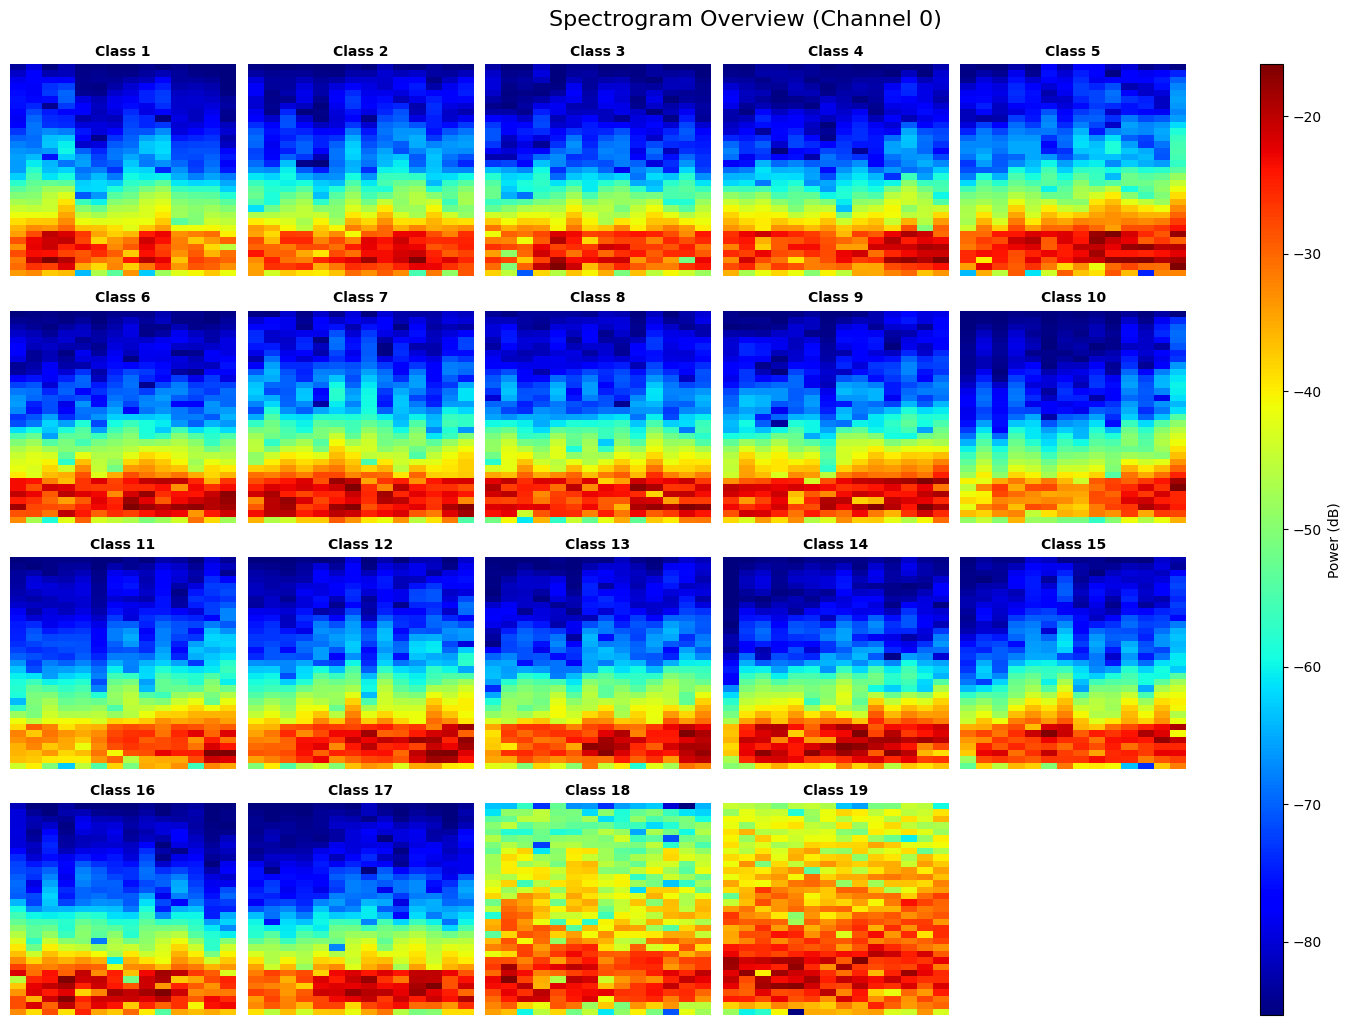

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import math

def plot_all_classes_overview(X, y, channel_idx=0, cols=5):
    """
    모든 클래스의 첫 번째 샘플을 찾아 그리드 형태로 시각화합니다.
    Args:
        X: 스펙트로그램 데이터 (Batch, Freq, Time, Channel)
        y: 라벨 데이터
        channel_idx: 보고 싶은 센서 채널 (0~15)
        cols: 한 줄에 보여줄 그래프 개수
    """
    unique_classes = np.unique(y)
    unique_classes.sort()
    n_classes = len(unique_classes)
    
    rows = math.ceil(n_classes / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(3 * cols, 2.5 * rows))
    axes = axes.flatten() # 1차원 배열로 평탄화
    
    print(f"총 {n_classes}개의 클래스를 시각화합니다 (Channel {channel_idx})...")
    
    for i, cls in enumerate(unique_classes):
        # 해당 클래스의 인덱스 찾기
        indices = np.where(y == cls)[0]
        if len(indices) == 0: continue
            
        sample_idx = indices[0] # 첫 번째 샘플 선택
        
        # 스펙트로그램 추출 (Freq, Time)
        # X shape: (Batch, Freq, Time, Channel)
        spec_data = X[sample_idx, :, :, channel_idx]
        
        # 시각화
        ax = axes[i]
        im = ax.imshow(spec_data, aspect='auto', origin='lower', cmap='jet')
        ax.set_title(f"Class {int(cls)}", fontsize=10, fontweight='bold')
        ax.axis('off') # 축 눈금 제거 (깔끔하게 보기 위함)
        
    # 남은 빈 서브플롯 끄기
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
        
    plt.tight_layout()
    plt.suptitle(f"Spectrogram Overview (Channel {channel_idx})", y=1.02, fontsize=16)
    plt.colorbar(im, ax=axes.ravel().tolist(), label='Power (dB)', aspect=40)
    plt.show()

# 실행
plot_all_classes_overview(X_spectrogram, y_combined, channel_idx=0)

=== 클래스별 데이터 분포 (Class Distribution) ===
    Class Label  Count  Percentage (%)
0             1   4500            4.31
1             2   3684            3.53
2             3   3713            3.55
3             4   3779            3.62
4             5  11164           10.69
5             6  11242           10.76
6             7  11801           11.30
7             8   3653            3.50
8             9   4053            3.88
9            10   3817            3.65
10           11   4374            4.19
11           12   3882            3.72
12           13   3927            3.76
13           14   3432            3.29
14           15   3068            2.94
15           16   4488            4.30
16           17   4081            3.91
17           18   7905            7.57
18           19   7889            7.55
----------------------------------------
총 샘플 개수: 104452
총 클래스 종류: 19개
----------------------------------------


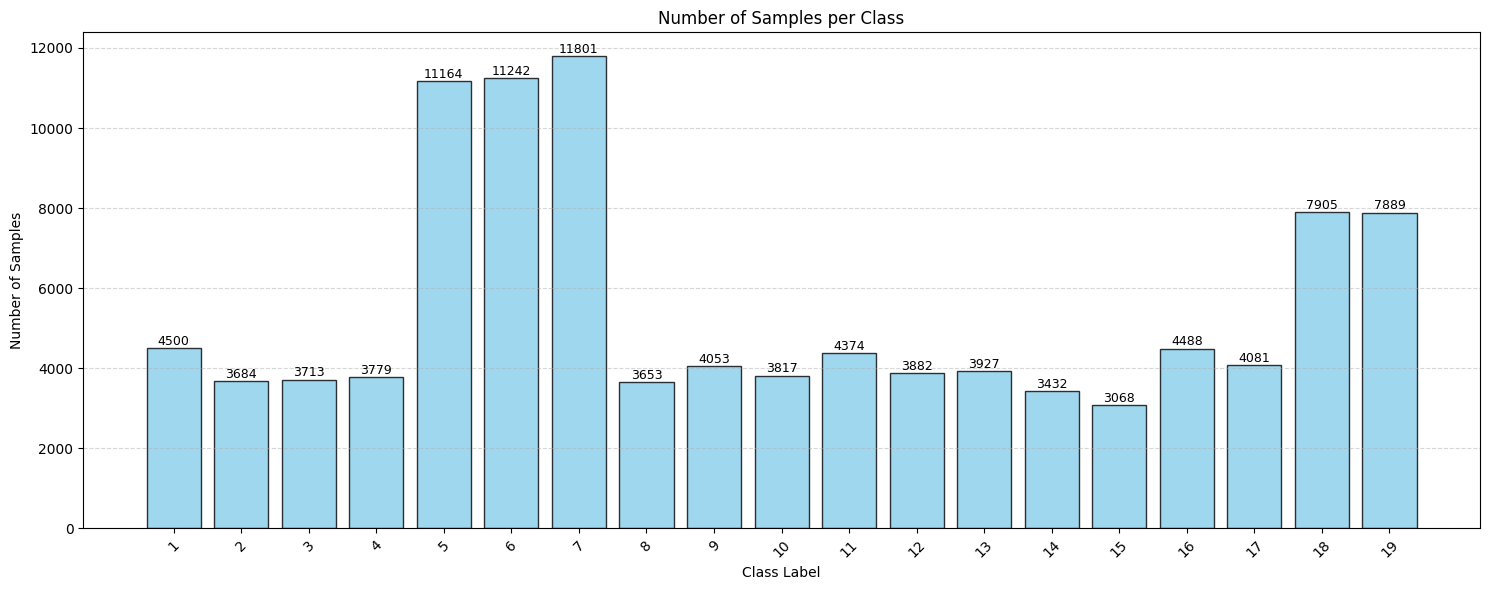

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def check_class_distribution(y):
    """
    라벨 데이터(y)의 클래스별 분포를 계산하고 시각화합니다.
    """
    
    # 1. 고유값 및 개수 계산
    unique_classes, counts = np.unique(y, return_counts=True)
    total_samples = len(y)
    
    # 2. 데이터프레임으로 정리 (보기 좋게 출력하기 위함)
    dist_df = pd.DataFrame({
        'Class Label': unique_classes.astype(int),
        'Count': counts,
        'Percentage (%)': np.round((counts / total_samples) * 100, 2)
    })
    
    # 클래스 라벨 순으로 정렬
    dist_df = dist_df.sort_values('Class Label').reset_index(drop=True)
    
    print("=== 클래스별 데이터 분포 (Class Distribution) ===")
    print(dist_df)
    print("-" * 40)
    print(f"총 샘플 개수: {total_samples}")
    print(f"총 클래스 종류: {len(unique_classes)}개")
    print("-" * 40)
    
    # 3. 막대 그래프 시각화
    plt.figure(figsize=(15, 6))
    bars = plt.bar(dist_df['Class Label'].astype(str), dist_df['Count'], 
                   color='skyblue', edgecolor='black', alpha=0.8)
    
    # 막대 위에 숫자 표시
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, height + 5, 
                 f'{int(height)}', ha='center', va='bottom', fontsize=9)
    
    plt.xlabel('Class Label')
    plt.ylabel('Number of Samples')
    plt.title('Number of Samples per Class')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.xticks(rotation=45) # 클래스가 많으면 X축 라벨 회전
    plt.tight_layout()
    plt.show()

# ========================================================
# 실행
# ========================================================
check_class_distribution(y_combined)

데이터 전처리 시작...
Train Shape: (62671, 33, 14, 16)
Val Shape: (20890, 33, 14, 16)
Test Shape: (20891, 33, 14, 16)


Model: "STFT_Attention_Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 33, 14,    │          0 │ -                 │
│ (InputLayer)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 33, 14,    │      4,640 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 33, 14,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 33, 14,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 16, 14,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 16, 14,    │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 16, 14,    │     18,496 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 14,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 16, 14,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 8, 14, 64) │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 8, 14, 64) │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 8, 14,     │     73,856 │ dropout_1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 14,     │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 8, 14,     │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 4, 7, 128) │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 4, 7, 128) │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 7, 512)    │          0 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 7, 512)    │    525,568 │ reshape[0][0],  

 Total params: 693,107 (2.64 MB)

 Trainable params: 692,403 (2.64 MB)

 Non-trainable params: 704 (2.75 KB)


=== STFT + Attention 모델 학습 시작 ===
Epoch 1/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.1565 - loss: 2.5253
Epoch 1: val_accuracy improved from None to 0.11360, saving model to best_stft_attention_model.h5


980/980 ━━━━━━━━━━━━━━━━━━━━ 58s 57ms/step - accuracy: 0.1946 - loss: 2.3571 - val_accuracy: 0.1136 - val_loss: 3.0612 - learning_rate: 0.0010
Epoch 2/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.3022 - loss: 2.0572
Epoch 2: val_accuracy improved from 0.11360 to 0.21886, saving model to best_stft_attention_model.h5


980/980 ━━━━━━━━━━━━━━━━━━━━ 56s 58ms/step - accuracy: 0.3352 - loss: 1.9715 - val_accuracy: 0.2189 - val_loss: 2.5545 - learning_rate: 0.0010
Epoch 3/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.4054 - loss: 1.7787
Epoch 3: val_accuracy improved from 0.21886 to 0.29713, saving model to best_stft_attention_model.h5


980/980 ━━━━━━━━━━━━━━━━━━━━ 58s 59ms/step - accuracy: 0.4183 - loss: 1.7429 - val_accuracy: 0.2971 - val_loss: 2.1432 - learning_rate: 0.0010
Epoch 4/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.4465 - loss: 1.6543
Epoch 4: val_accuracy improved from 0.29713 to 0.41192, saving model to best_stft_attention_model.h5


980/980 ━━━━━━━━━━━━━━━━━━━━ 57s 58ms/step - accuracy: 0.4568 - loss: 1.6257 - val_accuracy: 0.4119 - val_loss: 1.7695 - learning_rate: 0.0010
Epoch 5/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.4858 - loss: 1.5399
Epoch 5: val_accuracy improved from 0.41192 to 0.42494, saving model to best_stft_attention_model.h5


980/980 ━━━━━━━━━━━━━━━━━━━━ 58s 59ms/step - accuracy: 0.4936 - loss: 1.5179 - val_accuracy: 0.4249 - val_loss: 1.7556 - learning_rate: 0.0010
Epoch 6/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.5078 - loss: 1.4761
Epoch 6: val_accuracy improved from 0.42494 to 0.45060, saving model to best_stft_attention_model.h5


980/980 ━━━━━━━━━━━━━━━━━━━━ 57s 58ms/step - accuracy: 0.5152 - loss: 1.4550 - val_accuracy: 0.4506 - val_loss: 1.6710 - learning_rate: 0.0010
Epoch 7/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.5351 - loss: 1.4032
Epoch 7: val_accuracy improved from 0.45060 to 0.54337, saving model to best_stft_attention_model.h5


980/980 ━━━━━━━━━━━━━━━━━━━━ 58s 60ms/step - accuracy: 0.5388 - loss: 1.3858 - val_accuracy: 0.5434 - val_loss: 1.3393 - learning_rate: 0.0010
Epoch 8/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.5464 - loss: 1.3592
Epoch 8: val_accuracy did not improve from 0.54337
980/980 ━━━━━━━━━━━━━━━━━━━━ 57s 58ms/step - accuracy: 0.5540 - loss: 1.3433 - val_accuracy: 0.4999 - val_loss: 1.5028 - learning_rate: 0.0010
Epoch 9/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.5597 - loss: 1.3172
Epoch 9: val_accuracy did not improve from 0.54337
980/980 ━━━━━━━━━━━━━━━━━━━━ 57s 59ms/step - accuracy: 0.5659 - loss: 1.3030 - val_accuracy: 0.5190 - val_loss: 1.4319 - learning_rate: 0.0010
Epoch 10/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.5776 - loss: 1.2650
Epoch 10: val_accuracy improved from 0.54337 to 0.55385, saving model to best_stft_attention_model.h5


980/980 ━━━━━━━━━━━━━━━━━━━━ 57s 58ms/step - accuracy: 0.5806 - loss: 1.2602 - val_accuracy: 0.5539 - val_loss: 1.3205 - learning_rate: 0.0010
Epoch 11/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.5910 - loss: 1.2308
Epoch 11: val_accuracy improved from 0.55385 to 0.59684, saving model to best_stft_attention_model.h5


980/980 ━━━━━━━━━━━━━━━━━━━━ 56s 57ms/step - accuracy: 0.5908 - loss: 1.2280 - val_accuracy: 0.5968 - val_loss: 1.1810 - learning_rate: 0.0010
Epoch 12/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.5996 - loss: 1.2005
Epoch 12: val_accuracy did not improve from 0.59684
980/980 ━━━━━━━━━━━━━━━━━━━━ 57s 59ms/step - accuracy: 0.5983 - loss: 1.2052 - val_accuracy: 0.4869 - val_loss: 1.5952 - learning_rate: 0.0010
Epoch 13/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.6059 - loss: 1.1801
Epoch 13: val_accuracy did not improve from 0.59684
980/980 ━━━━━━━━━━━━━━━━━━━━ 61s 62ms/step - accuracy: 0.6065 - loss: 1.1768 - val_accuracy: 0.5618 - val_loss: 1.3513 - learning_rate: 0.0010
Epoch 14/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.6188 - loss: 1.1415
Epoch 14: val_accuracy improved from 0.59684 to 0.61407, saving model to best_stft_attention_model.h5


980/980 ━━━━━━━━━━━━━━━━━━━━ 59s 60ms/step - accuracy: 0.6162 - loss: 1.1443 - val_accuracy: 0.6141 - val_loss: 1.1423 - learning_rate: 0.0010
Epoch 15/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6289 - loss: 1.1190
Epoch 15: val_accuracy improved from 0.61407 to 0.62326, saving model to best_stft_attention_model.h5


980/980 ━━━━━━━━━━━━━━━━━━━━ 57s 58ms/step - accuracy: 0.6261 - loss: 1.1212 - val_accuracy: 0.6233 - val_loss: 1.1244 - learning_rate: 0.0010
Epoch 16/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.6332 - loss: 1.1098
Epoch 16: val_accuracy did not improve from 0.62326
980/980 ━━━━━━━━━━━━━━━━━━━━ 57s 58ms/step - accuracy: 0.6325 - loss: 1.1076 - val_accuracy: 0.5800 - val_loss: 1.2584 - learning_rate: 0.0010
Epoch 17/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.6359 - loss: 1.0939
Epoch 17: val_accuracy improved from 0.62326 to 0.66405, saving model to best_stft_attention_model.h5


980/980 ━━━━━━━━━━━━━━━━━━━━ 57s 58ms/step - accuracy: 0.6362 - loss: 1.0869 - val_accuracy: 0.6640 - val_loss: 0.9767 - learning_rate: 0.0010
Epoch 18/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6439 - loss: 1.0684
Epoch 18: val_accuracy did not improve from 0.66405
980/980 ━━━━━━━━━━━━━━━━━━━━ 57s 58ms/step - accuracy: 0.6423 - loss: 1.0685 - val_accuracy: 0.5870 - val_loss: 1.2637 - learning_rate: 0.0010
Epoch 19/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6502 - loss: 1.0479
Epoch 19: val_accuracy did not improve from 0.66405
980/980 ━━━━━━━━━━━━━━━━━━━━ 57s 58ms/step - accuracy: 0.6502 - loss: 1.0487 - val_accuracy: 0.6222 - val_loss: 1.1246 - learning_rate: 0.0010
Epoch 20/100
980/980 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.6551 - loss: 1.0327
Epoch 20: val_accuracy improved from 0.66405 to 0.66458, saving model to best_stft_attention_model.h5


980/980 ━━━━━━━━━━━━━━━━━━━━ 58s 59ms/step - accuracy: 0.6567 - loss: 1.0245 - val_accuracy: 0.6646 - val_loss: 0.9873 - learning_rate: 0.0010
Epoch 21/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.6636 - loss: 1.0102
Epoch 21: val_accuracy did not improve from 0.66458
980/980 ━━━━━━━━━━━━━━━━━━━━ 57s 58ms/step - accuracy: 0.6601 - loss: 1.0134 - val_accuracy: 0.5159 - val_loss: 2.1787 - learning_rate: 0.0010
Epoch 22/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6677 - loss: 0.9993
Epoch 22: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 22: val_accuracy did not improve from 0.66458
980/980 ━━━━━━━━━━━━━━━━━━━━ 57s 58ms/step - accuracy: 0.6637 - loss: 1.0023 - val_accuracy: 0.6519 - val_loss: 1.0428 - learning_rate: 0.0010
Epoch 23/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6773 - loss: 0.9576
Epoch 23: val_accuracy improved from 0.66458 to 0.71015, saving model to best_stft_attention_model.h5


980/980 ━━━━━━━━━━━━━━━━━━━━ 56s 57ms/step - accuracy: 0.6808 - loss: 0.9504 - val_accuracy: 0.7101 - val_loss: 0.8482 - learning_rate: 5.0000e-04
Epoch 24/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6874 - loss: 0.9316
Epoch 24: val_accuracy improved from 0.71015 to 0.72858, saving model to best_stft_attention_model.h5


980/980 ━━━━━━━━━━━━━━━━━━━━ 57s 58ms/step - accuracy: 0.6864 - loss: 0.9360 - val_accuracy: 0.7286 - val_loss: 0.7965 - learning_rate: 5.0000e-04
Epoch 25/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.6921 - loss: 0.9228
Epoch 25: val_accuracy did not improve from 0.72858
980/980 ━━━━━━━━━━━━━━━━━━━━ 56s 57ms/step - accuracy: 0.6921 - loss: 0.9220 - val_accuracy: 0.7045 - val_loss: 0.8744 - learning_rate: 5.0000e-04
Epoch 26/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.6920 - loss: 0.9166
Epoch 26: val_accuracy did not improve from 0.72858
980/980 ━━━━━━━━━━━━━━━━━━━━ 57s 59ms/step - accuracy: 0.6926 - loss: 0.9179 - val_accuracy: 0.7026 - val_loss: 0.8867 - learning_rate: 5.0000e-04
Epoch 27/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.6972 - loss: 0.9080
Epoch 27: val_accuracy did not improve from 0.72858
980/980 ━━━━━━━━━━━━━━━━━━━━ 58s 59ms/step - accuracy: 0.6950 - loss: 0.9088 - val_accuracy: 0.7068 - val_loss: 0.8637 - learning_rate: 

980/980 ━━━━━━━━━━━━━━━━━━━━ 57s 58ms/step - accuracy: 0.7085 - loss: 0.8682 - val_accuracy: 0.7571 - val_loss: 0.7143 - learning_rate: 2.5000e-04
Epoch 31/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7113 - loss: 0.8649
Epoch 31: val_accuracy improved from 0.75706 to 0.76908, saving model to best_stft_attention_model.h5


980/980 ━━━━━━━━━━━━━━━━━━━━ 58s 59ms/step - accuracy: 0.7106 - loss: 0.8659 - val_accuracy: 0.7691 - val_loss: 0.6830 - learning_rate: 2.5000e-04
Epoch 32/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7118 - loss: 0.8656
Epoch 32: val_accuracy did not improve from 0.76908
980/980 ━━━━━━━━━━━━━━━━━━━━ 57s 58ms/step - accuracy: 0.7135 - loss: 0.8591 - val_accuracy: 0.7602 - val_loss: 0.7046 - learning_rate: 2.5000e-04
Epoch 33/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7165 - loss: 0.8432
Epoch 33: val_accuracy did not improve from 0.76908
980/980 ━━━━━━━━━━━━━━━━━━━━ 56s 57ms/step - accuracy: 0.7152 - loss: 0.8517 - val_accuracy: 0.7610 - val_loss: 0.7017 - learning_rate: 2.5000e-04
Epoch 34/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7165 - loss: 0.8415
Epoch 34: val_accuracy did not improve from 0.76908
980/980 ━━━━━━━━━━━━━━━━━━━━ 57s 58ms/step - accuracy: 0.7161 - loss: 0.8453 - val_accuracy: 0.7502 - val_loss: 0.7245 - learning_rate: 

980/980 ━━━━━━━━━━━━━━━━━━━━ 56s 57ms/step - accuracy: 0.7186 - loss: 0.8375 - val_accuracy: 0.7730 - val_loss: 0.6596 - learning_rate: 2.5000e-04
Epoch 37/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7209 - loss: 0.8364
Epoch 37: val_accuracy did not improve from 0.77295
980/980 ━━━━━━━━━━━━━━━━━━━━ 56s 58ms/step - accuracy: 0.7182 - loss: 0.8412 - val_accuracy: 0.7698 - val_loss: 0.6647 - learning_rate: 2.5000e-04
Epoch 38/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7220 - loss: 0.8320
Epoch 38: val_accuracy did not improve from 0.77295
980/980 ━━━━━━━━━━━━━━━━━━━━ 57s 58ms/step - accuracy: 0.7209 - loss: 0.8351 - val_accuracy: 0.7644 - val_loss: 0.6816 - learning_rate: 2.5000e-04
Epoch 39/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7238 - loss: 0.8210
Epoch 39: val_accuracy did not improve from 0.77295
980/980 ━━━━━━━━━━━━━━━━━━━━ 57s 58ms/step - accuracy: 0.7222 - loss: 0.8281 - val_accuracy: 0.7692 - val_loss: 0.6755 - learning_rate: 

980/980 ━━━━━━━━━━━━━━━━━━━━ 57s 58ms/step - accuracy: 0.7237 - loss: 0.8235 - val_accuracy: 0.7796 - val_loss: 0.6521 - learning_rate: 2.5000e-04
Epoch 42/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7240 - loss: 0.8194
Epoch 42: val_accuracy did not improve from 0.77956
980/980 ━━━━━━━━━━━━━━━━━━━━ 58s 59ms/step - accuracy: 0.7228 - loss: 0.8246 - val_accuracy: 0.7737 - val_loss: 0.6608 - learning_rate: 2.5000e-04
Epoch 43/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7257 - loss: 0.8172
Epoch 43: val_accuracy did not improve from 0.77956
980/980 ━━━━━━━━━━━━━━━━━━━━ 58s 59ms/step - accuracy: 0.7250 - loss: 0.8208 - val_accuracy: 0.7593 - val_loss: 0.7048 - learning_rate: 2.5000e-04
Epoch 44/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7239 - loss: 0.8247
Epoch 44: val_accuracy did not improve from 0.77956
980/980 ━━━━━━━━━━━━━━━━━━━━ 57s 58ms/step - accuracy: 0.7259 - loss: 0.8195 - val_accuracy: 0.7733 - val_loss: 0.6665 - learning_rate: 

980/980 ━━━━━━━━━━━━━━━━━━━━ 57s 58ms/step - accuracy: 0.7312 - loss: 0.7938 - val_accuracy: 0.7894 - val_loss: 0.6157 - learning_rate: 1.2500e-04
Epoch 48/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7341 - loss: 0.7874
Epoch 48: val_accuracy did not improve from 0.78942
980/980 ━━━━━━━━━━━━━━━━━━━━ 57s 58ms/step - accuracy: 0.7336 - loss: 0.7914 - val_accuracy: 0.7861 - val_loss: 0.6298 - learning_rate: 1.2500e-04
Epoch 49/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7323 - loss: 0.7956
Epoch 49: val_accuracy improved from 0.78942 to 0.78980, saving model to best_stft_attention_model.h5


980/980 ━━━━━━━━━━━━━━━━━━━━ 58s 59ms/step - accuracy: 0.7343 - loss: 0.7917 - val_accuracy: 0.7898 - val_loss: 0.6243 - learning_rate: 1.2500e-04
Epoch 50/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7318 - loss: 0.7924
Epoch 50: val_accuracy improved from 0.78980 to 0.79239, saving model to best_stft_attention_model.h5


980/980 ━━━━━━━━━━━━━━━━━━━━ 57s 58ms/step - accuracy: 0.7330 - loss: 0.7892 - val_accuracy: 0.7924 - val_loss: 0.6076 - learning_rate: 1.2500e-04
Epoch 51/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7345 - loss: 0.7899
Epoch 51: val_accuracy improved from 0.79239 to 0.79339, saving model to best_stft_attention_model.h5


980/980 ━━━━━━━━━━━━━━━━━━━━ 58s 59ms/step - accuracy: 0.7349 - loss: 0.7909 - val_accuracy: 0.7934 - val_loss: 0.6123 - learning_rate: 1.2500e-04
Epoch 52/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7375 - loss: 0.7772
Epoch 52: val_accuracy improved from 0.79339 to 0.79382, saving model to best_stft_attention_model.h5


980/980 ━━━━━━━━━━━━━━━━━━━━ 57s 58ms/step - accuracy: 0.7353 - loss: 0.7859 - val_accuracy: 0.7938 - val_loss: 0.6094 - learning_rate: 1.2500e-04
Epoch 53/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7355 - loss: 0.7832
Epoch 53: val_accuracy improved from 0.79382 to 0.79560, saving model to best_stft_attention_model.h5


980/980 ━━━━━━━━━━━━━━━━━━━━ 57s 59ms/step - accuracy: 0.7349 - loss: 0.7829 - val_accuracy: 0.7956 - val_loss: 0.6082 - learning_rate: 1.2500e-04
Epoch 54/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7385 - loss: 0.7760
Epoch 54: val_accuracy did not improve from 0.79560
980/980 ━━━━━━━━━━━━━━━━━━━━ 57s 58ms/step - accuracy: 0.7384 - loss: 0.7805 - val_accuracy: 0.7925 - val_loss: 0.6129 - learning_rate: 1.2500e-04
Epoch 55/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7390 - loss: 0.7750
Epoch 55: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 55: val_accuracy did not improve from 0.79560
980/980 ━━━━━━━━━━━━━━━━━━━━ 57s 59ms/step - accuracy: 0.7374 - loss: 0.7804 - val_accuracy: 0.7923 - val_loss: 0.6077 - learning_rate: 1.2500e-04
Epoch 56/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7404 - loss: 0.7740
Epoch 56: val_accuracy did not improve from 0.79560
980/980 ━━━━━━━━━━━━━━━━━━━━ 57s 59ms/step - accuracy: 0.74

980/980 ━━━━━━━━━━━━━━━━━━━━ 57s 58ms/step - accuracy: 0.7397 - loss: 0.7730 - val_accuracy: 0.7966 - val_loss: 0.5946 - learning_rate: 6.2500e-05
Epoch 58/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7423 - loss: 0.7714
Epoch 58: val_accuracy did not improve from 0.79660
980/980 ━━━━━━━━━━━━━━━━━━━━ 57s 58ms/step - accuracy: 0.7416 - loss: 0.7732 - val_accuracy: 0.7922 - val_loss: 0.6100 - learning_rate: 6.2500e-05
Epoch 59/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7426 - loss: 0.7642
Epoch 59: val_accuracy improved from 0.79660 to 0.79861, saving model to best_stft_attention_model.h5


980/980 ━━━━━━━━━━━━━━━━━━━━ 56s 58ms/step - accuracy: 0.7420 - loss: 0.7692 - val_accuracy: 0.7986 - val_loss: 0.5900 - learning_rate: 6.2500e-05
Epoch 60/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7403 - loss: 0.7697
Epoch 60: val_accuracy did not improve from 0.79861
980/980 ━━━━━━━━━━━━━━━━━━━━ 57s 59ms/step - accuracy: 0.7418 - loss: 0.7687 - val_accuracy: 0.7965 - val_loss: 0.5965 - learning_rate: 6.2500e-05
Epoch 61/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7412 - loss: 0.7657
Epoch 61: val_accuracy improved from 0.79861 to 0.79957, saving model to best_stft_attention_model.h5


980/980 ━━━━━━━━━━━━━━━━━━━━ 56s 58ms/step - accuracy: 0.7423 - loss: 0.7686 - val_accuracy: 0.7996 - val_loss: 0.5897 - learning_rate: 6.2500e-05
Epoch 62/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7426 - loss: 0.7698
Epoch 62: val_accuracy improved from 0.79957 to 0.80010, saving model to best_stft_attention_model.h5


980/980 ━━━━━━━━━━━━━━━━━━━━ 57s 58ms/step - accuracy: 0.7428 - loss: 0.7687 - val_accuracy: 0.8001 - val_loss: 0.5869 - learning_rate: 6.2500e-05
Epoch 63/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7440 - loss: 0.7630
Epoch 63: val_accuracy did not improve from 0.80010
980/980 ━━━━━━━━━━━━━━━━━━━━ 57s 58ms/step - accuracy: 0.7416 - loss: 0.7664 - val_accuracy: 0.7991 - val_loss: 0.5949 - learning_rate: 6.2500e-05
Epoch 64/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7471 - loss: 0.7537
Epoch 64: val_accuracy improved from 0.80010 to 0.80139, saving model to best_stft_attention_model.h5


980/980 ━━━━━━━━━━━━━━━━━━━━ 58s 59ms/step - accuracy: 0.7442 - loss: 0.7617 - val_accuracy: 0.8014 - val_loss: 0.5880 - learning_rate: 6.2500e-05
Epoch 65/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7433 - loss: 0.7586
Epoch 65: val_accuracy did not improve from 0.80139
980/980 ━━━━━━━━━━━━━━━━━━━━ 57s 58ms/step - accuracy: 0.7435 - loss: 0.7633 - val_accuracy: 0.7997 - val_loss: 0.5880 - learning_rate: 6.2500e-05
Epoch 66/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7435 - loss: 0.7662
Epoch 66: val_accuracy did not improve from 0.80139
980/980 ━━━━━━━━━━━━━━━━━━━━ 57s 59ms/step - accuracy: 0.7421 - loss: 0.7689 - val_accuracy: 0.7994 - val_loss: 0.5909 - learning_rate: 6.2500e-05
Epoch 67/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7395 - loss: 0.7715
Epoch 67: val_accuracy did not improve from 0.80139
980/980 ━━━━━━━━━━━━━━━━━━━━ 58s 59ms/step - accuracy: 0.7407 - loss: 0.7699 - val_accuracy: 0.8014 - val_loss: 0.5866 - learning_rate: 

980/980 ━━━━━━━━━━━━━━━━━━━━ 56s 57ms/step - accuracy: 0.7430 - loss: 0.7657 - val_accuracy: 0.8041 - val_loss: 0.5811 - learning_rate: 6.2500e-05
Epoch 70/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7469 - loss: 0.7565
Epoch 70: val_accuracy improved from 0.80412 to 0.80464, saving model to best_stft_attention_model.h5


980/980 ━━━━━━━━━━━━━━━━━━━━ 55s 57ms/step - accuracy: 0.7449 - loss: 0.7598 - val_accuracy: 0.8046 - val_loss: 0.5775 - learning_rate: 6.2500e-05
Epoch 71/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7431 - loss: 0.7594
Epoch 71: val_accuracy did not improve from 0.80464
980/980 ━━━━━━━━━━━━━━━━━━━━ 56s 57ms/step - accuracy: 0.7427 - loss: 0.7642 - val_accuracy: 0.8032 - val_loss: 0.5842 - learning_rate: 6.2500e-05
Epoch 72/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7433 - loss: 0.7611
Epoch 72: val_accuracy did not improve from 0.80464
980/980 ━━━━━━━━━━━━━━━━━━━━ 56s 57ms/step - accuracy: 0.7439 - loss: 0.7595 - val_accuracy: 0.8009 - val_loss: 0.5864 - learning_rate: 6.2500e-05
Epoch 73/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7449 - loss: 0.7530
Epoch 73: val_accuracy did not improve from 0.80464
980/980 ━━━━━━━━━━━━━━━━━━━━ 56s 57ms/step - accuracy: 0.7441 - loss: 0.7573 - val_accuracy: 0.8015 - val_loss: 0.5831 - learning_rate: 

980/980 ━━━━━━━━━━━━━━━━━━━━ 57s 58ms/step - accuracy: 0.7472 - loss: 0.7524 - val_accuracy: 0.8059 - val_loss: 0.5773 - learning_rate: 3.1250e-05
Epoch 78/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7468 - loss: 0.7540
Epoch 78: val_accuracy improved from 0.80589 to 0.80747, saving model to best_stft_attention_model.h5


980/980 ━━━━━━━━━━━━━━━━━━━━ 56s 57ms/step - accuracy: 0.7478 - loss: 0.7535 - val_accuracy: 0.8075 - val_loss: 0.5716 - learning_rate: 3.1250e-05
Epoch 79/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7469 - loss: 0.7543
Epoch 79: val_accuracy did not improve from 0.80747
980/980 ━━━━━━━━━━━━━━━━━━━━ 56s 57ms/step - accuracy: 0.7444 - loss: 0.7583 - val_accuracy: 0.8057 - val_loss: 0.5724 - learning_rate: 3.1250e-05
Epoch 80/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7490 - loss: 0.7514
Epoch 80: val_accuracy improved from 0.80747 to 0.80756, saving model to best_stft_attention_model.h5


980/980 ━━━━━━━━━━━━━━━━━━━━ 56s 57ms/step - accuracy: 0.7485 - loss: 0.7500 - val_accuracy: 0.8076 - val_loss: 0.5710 - learning_rate: 3.1250e-05
Epoch 81/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7489 - loss: 0.7478
Epoch 81: val_accuracy did not improve from 0.80756
980/980 ━━━━━━━━━━━━━━━━━━━━ 57s 58ms/step - accuracy: 0.7484 - loss: 0.7515 - val_accuracy: 0.8061 - val_loss: 0.5706 - learning_rate: 3.1250e-05
Epoch 82/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7476 - loss: 0.7516
Epoch 82: val_accuracy did not improve from 0.80756
980/980 ━━━━━━━━━━━━━━━━━━━━ 57s 58ms/step - accuracy: 0.7473 - loss: 0.7531 - val_accuracy: 0.8064 - val_loss: 0.5719 - learning_rate: 3.1250e-05
Epoch 83/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7490 - loss: 0.7423
Epoch 83: val_accuracy did not improve from 0.80756
980/980 ━━━━━━━━━━━━━━━━━━━━ 56s 57ms/step - accuracy: 0.7472 - loss: 0.7526 - val_accuracy: 0.8075 - val_loss: 0.5684 - learning_rate: 

980/980 ━━━━━━━━━━━━━━━━━━━━ 56s 57ms/step - accuracy: 0.7486 - loss: 0.7501 - val_accuracy: 0.8079 - val_loss: 0.5659 - learning_rate: 1.5625e-05
Epoch 90/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7479 - loss: 0.7572
Epoch 90: val_accuracy did not improve from 0.80795
980/980 ━━━━━━━━━━━━━━━━━━━━ 56s 57ms/step - accuracy: 0.7478 - loss: 0.7525 - val_accuracy: 0.8073 - val_loss: 0.5683 - learning_rate: 1.5625e-05
Epoch 91/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7502 - loss: 0.7436
Epoch 91: val_accuracy did not improve from 0.80795
980/980 ━━━━━━━━━━━━━━━━━━━━ 56s 57ms/step - accuracy: 0.7484 - loss: 0.7458 - val_accuracy: 0.8057 - val_loss: 0.5699 - learning_rate: 1.5625e-05
Epoch 92/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7495 - loss: 0.7488
Epoch 92: val_accuracy did not improve from 0.80795
980/980 ━━━━━━━━━━━━━━━━━━━━ 56s 57ms/step - accuracy: 0.7477 - loss: 0.7519 - val_accuracy: 0.8067 - val_loss: 0.5680 - learning_rate: 

980/980 ━━━━━━━━━━━━━━━━━━━━ 58s 59ms/step - accuracy: 0.7498 - loss: 0.7444 - val_accuracy: 0.8085 - val_loss: 0.5645 - learning_rate: 7.8125e-06
Epoch 97/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7524 - loss: 0.7299
Epoch 97: val_accuracy improved from 0.80852 to 0.80986, saving model to best_stft_attention_model.h5


980/980 ━━━━━━━━━━━━━━━━━━━━ 56s 57ms/step - accuracy: 0.7499 - loss: 0.7396 - val_accuracy: 0.8099 - val_loss: 0.5616 - learning_rate: 7.8125e-06
Epoch 98/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7544 - loss: 0.7380
Epoch 98: val_accuracy did not improve from 0.80986
980/980 ━━━━━━━━━━━━━━━━━━━━ 57s 58ms/step - accuracy: 0.7511 - loss: 0.7422 - val_accuracy: 0.8081 - val_loss: 0.5657 - learning_rate: 7.8125e-06
Epoch 99/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7455 - loss: 0.7530
Epoch 99: val_accuracy did not improve from 0.80986
980/980 ━━━━━━━━━━━━━━━━━━━━ 56s 58ms/step - accuracy: 0.7498 - loss: 0.7445 - val_accuracy: 0.8086 - val_loss: 0.5646 - learning_rate: 7.8125e-06
Epoch 100/100
979/980 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7484 - loss: 0.7462
Epoch 100: val_accuracy did not improve from 0.80986
980/980 ━━━━━━━━━━━━━━━━━━━━ 57s 58ms/step - accuracy: 0.7502 - loss: 0.7442 - val_accuracy: 0.8089 - val_loss: 0.5646 - learning_rate

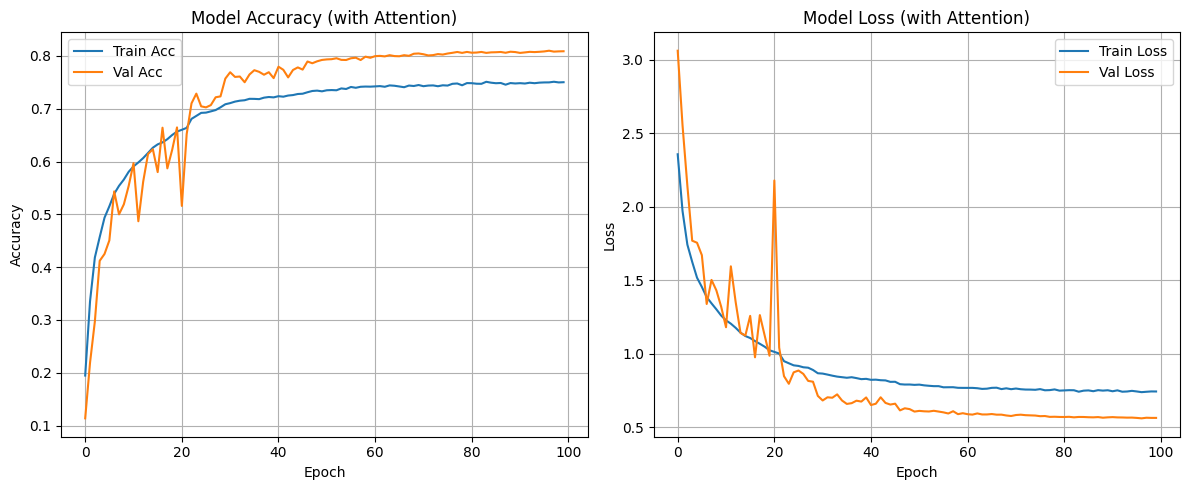

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight  # [추가됨] 가중치 계산용
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
# ==========================================
# 1. STFT + Attention 모델 정의
# ==========================================


print("데이터 전처리 시작...")

# 1-1. 클래스 라벨 One-Hot Encoding
num_classes = len(np.unique(y_combined))

# 라벨이 1부터 시작하면 0으로 보정
if np.min(y_combined) > 0:
    y_adjusted = y_combined - np.min(y_combined)
else:
    y_adjusted = y_combined

y_onehot = to_categorical(y_adjusted, num_classes=num_classes)

# 1-2. Train / Validation / Test 분리 (6:2:2 비율)
# Stratify를 사용하여 클래스 비율 유지
X_train, X_temp, y_train, y_temp = train_test_split(
    X_spectrogram, y_onehot, test_size=0.4, random_state=42, stratify=y_adjusted
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=np.argmax(y_temp, axis=1)
)

print(f"Train Shape: {X_train.shape}")
print(f"Val Shape: {X_val.shape}")
print(f"Test Shape: {X_test.shape}")



def build_stft_attention_model(input_shape, num_classes):
    """
    STFT 스펙트로그램을 위한 CNN + Self-Attention 모델
    Input Shape: (Freq_bins, Time_steps, Channels)
    """
    inputs = Input(shape=input_shape)
    
    # ---------------------------------------------------------
    # [Block 1] CNN Encoder: 공간적/주파수 특징 추출
    # ---------------------------------------------------------
    # Spectrogram의 Freq축과 Time축 특징을 동시에 잡습니다.
    x = Conv2D(32, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 1))(x) # 주파수 해상도만 줄이고 시간 정보는 최대한 보존
    x = Dropout(0.2)(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 1))(x) # 주파수 축만 Downsampling
    x = Dropout(0.3)(x)
    
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # 여기서부터는 이미지 크기가 작아지므로 Pooling 조심
    x = MaxPooling2D(pool_size=(2, 2))(x) 
    x = Dropout(0.3)(x)

    # ---------------------------------------------------------
    # [Block 2] Sequence Transformation (Reshape)
    # ---------------------------------------------------------
    # Attention을 적용하기 위해 (Batch, Freq, Time, Ch) -> (Batch, Time, Features)로 변환
    # CNN을 통과한 후의 Shape을 확인해야 함.
    # 예: (Batch, H, W, C) -> (Batch, W, H*C) 형태로 변경하여 '시간(W)'을 시퀀스로 취급
    
    shape = x.shape
    # shape[1] = Height(Freq), shape[2] = Width(Time), shape[3] = Channels
    # Time 축을 보존하면서 나머지를 Feature로 합침
    x = Reshape((shape[2], shape[1] * shape[3]))(x)
    
    # ---------------------------------------------------------
    # [Block 3] Multi-Head Self Attention
    # ---------------------------------------------------------
    # 시간 축(Time segments) 간의 관계를 파악하여 중요한 타이밍에 집중
    
    # Attention Layer
    # key_dim: Attention 내부 차원 크기
    # num_heads: 몇 개의 관점으로 볼 것인지 (보통 4~8)
    attn_out = MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
    
    # Residual Connection (기존 정보 + Attention 정보) & Normalization
    x = Add()([x, attn_out])
    x = LayerNormalization(epsilon=1e-6)(x)
    x = Dropout(0.4)(x)

    # ---------------------------------------------------------
    # [Block 4] Classifier
    # ---------------------------------------------------------
    # 시계열 정보를 하나로 압축 (Global Average Pooling)
    x = GlobalAveragePooling1D()(x)
    
    x = Dense(128)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs, name="STFT_Attention_Net")
    return model

# ==========================================
# 2. 모델 생성 및 컴파일
# ==========================================

# X_train이 메모리에 있다고 가정 (이전 단계에서 생성됨)
input_shape = X_train.shape[1:] # (Freq, Time, 16)
num_classes = y_onehot.shape[1] # 클래스 개수

model = build_stft_attention_model(input_shape, num_classes)

# 학습률(Learning Rate) 설정
optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# ==========================================
# 3. 모델 학습 (Training)
# ==========================================

# 콜백 정의
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
    ModelCheckpoint('best_stft_attention_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
]

print("\n=== STFT + Attention 모델 학습 시작 ===")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,            # 충분히 설정 (EarlyStopping이 멈춰줌)
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

# ==========================================
# 4. 결과 시각화
# ==========================================
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# 정확도 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy (with Attention)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss (with Attention)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

예측 및 정규화 수행 중...
653/653 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step


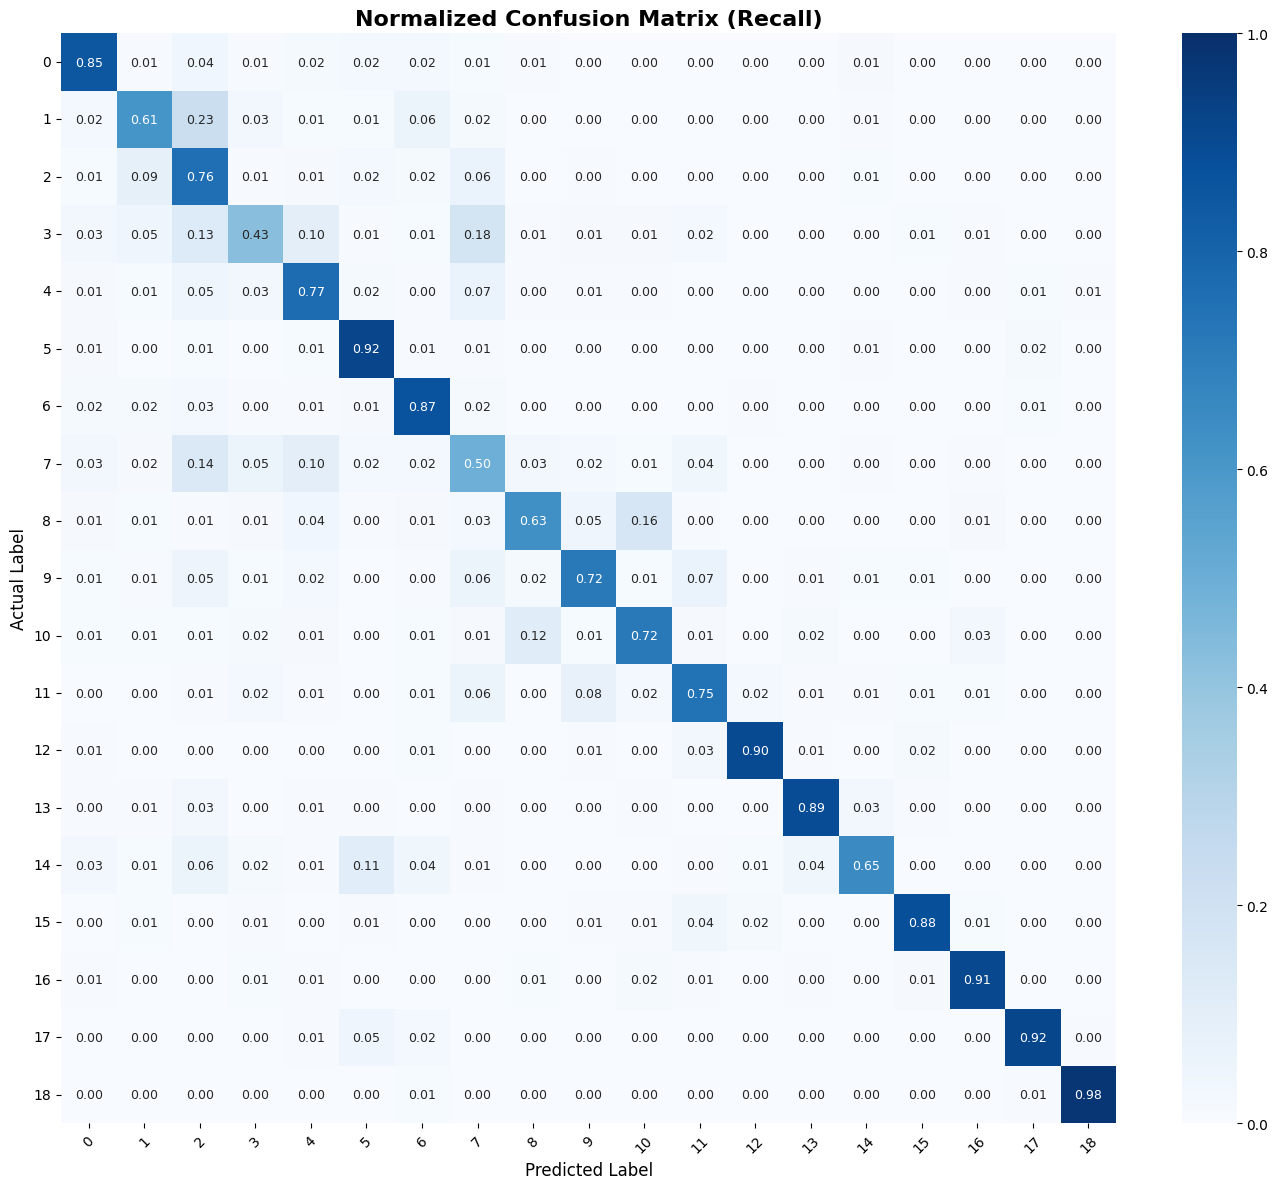

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

def plot_normalized_confusion_matrix(model, X_test, y_test):
    """
    각 클래스별 정답률을 0 ~ 1 사이의 값으로 정규화하여 보여주는 혼동 행렬입니다.
    대각선 값이 1.0에 가까울수록 해당 클래스의 분류가 완벽함을 의미합니다.
    """
    
    # 1. 모델 예측
    print("예측 및 정규화 수행 중...")
    y_pred_probs = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    
    # 2. 실제 라벨 변환 (One-hot -> Index)
    if y_test.ndim > 1:
        y_true_classes = np.argmax(y_test, axis=1)
    else:
        y_true_classes = y_test

    # 3. 혼동 행렬 계산 (정규화 옵션 추가)
    # normalize='true': 각 행(Actual Class)의 합이 1이 되도록 나눔
    cm_normalized = confusion_matrix(y_true_classes, y_pred_classes, normalize='true')
    
    unique_classes = np.unique(y_true_classes)
    
    # 4. 시각화
    plt.figure(figsize=(14, 12))
    
    sns.heatmap(cm_normalized, 
                annot=True,         # 숫자 표시
                fmt='.2f',          # 소수점 2자리까지 표시 (예: 0.95)
                cmap='Blues',       # 파란색 테마
                vmin=0.0, vmax=1.0, # 컬러바 범위를 0~1로 고정
                xticklabels=unique_classes,
                yticklabels=unique_classes,
                annot_kws={"size": 9}) # 글자 크기 조절
    
    plt.title('Normalized Confusion Matrix (Recall)', fontsize=16, fontweight='bold')
    plt.ylabel('Actual Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    plt.show()

# ==========================================
# 실행
# ==========================================
plot_normalized_confusion_matrix(model, X_test, y_test)

In [4]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score

def print_classification_counts(model, X_test, y_test):
    """
    각 클래스별로 실제 데이터 개수, 모델이 맞춘 개수, 틀린 개수, 
    그리고 분류 정확도(%)를 표(DataFrame) 형태로 출력합니다.
    """
    print("분류 결과 집계 중...")
    
    # 1. 모델 예측
    y_pred_probs = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)
    
    # 2. 실제 라벨 (One-hot -> Index 변환)
    if y_test.ndim > 1:
        y_true = np.argmax(y_test, axis=1)
    else:
        y_true = y_test
        
    # 3. 전체 정확도
    total_acc = accuracy_score(y_true, y_pred)
    print(f"\n=== 전체 정확도 (Overall Accuracy): {total_acc * 100:.2f}% ===\n")

    # 4. 혼동 행렬 계산 (Raw Counts)
    cm = confusion_matrix(y_true, y_pred)
    
    # 5. 클래스별 통계 계산
    results = []
    classes = np.unique(y_true)
    
    for cls in classes:
        # 해당 클래스의 행(Row) 인덱스
        idx = int(cls)
        
        # A. 실제 해당 클래스 데이터 총 개수 (Support) -> 행의 합
        total_actual = np.sum(cm[idx, :])
        
        # B. 모델이 정답을 맞춘 개수 (True Positive) -> 대각선 값
        correct = cm[idx, idx]
        
        # C. 모델이 해당 클래스로 예측한 총 개수 (Predicted Count) -> 열의 합
        total_predicted = np.sum(cm[:, idx])
        
        # D. 틀린 개수 (Wrong)
        wrong = total_actual - correct
        
        # E. 정확도 (Accuracy for this class)
        acc = (correct / total_actual) * 100 if total_actual > 0 else 0
        
        results.append({
            'Class Label': cls,
            'Total Samples': total_actual,   # 실제 데이터 수
            'Correct (TP)': correct,         # 맞춘 개수
            'Wrong': wrong,                  # 틀린 개수
            'Predicted Count': total_predicted, # 모델이 이 클래스라고 찍은 횟수
            'Accuracy (%)': round(acc, 2)    # 정답률
        })
        
    # 6. 데이터프레임 생성 및 출력
    df_results = pd.DataFrame(results)
    
    # 보기 좋게 출력
    print(df_results.to_string(index=False))
    
    return df_results

# ==========================================
# 실행
# ==========================================
stats_df = print_classification_counts(loaded_model, X_test, y_test)

NameError: name 'X_test' is not defined

In [3]:
import tensorflow as tf

model_path = '/Users/kimjunghyun/PJ_project/Project-Gesture-classification-technique-based-on-multiple-EMG-datasets/best_stft_attention_model.h5'

# 모델 불러오기
loaded_model = tf.keras.models.load_model(model_path)

# 불러온 모델 정보 확인
loaded_model.summary()


Model: "STFT_Attention_Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 33, 14,    │          0 │ -                 │
│ (InputLayer)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 33, 14,    │      4,640 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 33, 14,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 33, 14,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 16, 14,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 16, 14,    │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 16, 14,    │     18,496 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 14,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 16, 14,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 8, 14, 64) │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 8, 14, 64) │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 8, 14,     │     73,856 │ dropout_1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 14,     │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 8, 14,     │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 4, 7, 128) │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 4, 7, 128) │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 7, 512)    │          0 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 7, 512)    │    525,568 │ reshape[0][0],  

 Total params: 693,109 (2.64 MB)

 Trainable params: 692,403 (2.64 MB)

 Non-trainable params: 704 (2.75 KB)

 Optimizer params: 2 (12.00 B)